In [1]:
!pip install mpi4py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 21.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for mpi4py: filename=mpi4py-3.1.5-cp310-cp310-linux_x86_64.whl size=2746528 sha256=a237df4ecf73e45160f10ea2ffcf76721064321047193b706aac53087aca5d75
  Stored in directory: /root/.cache/pip/wheels/18/2b/7f/c852523089e9182b45fca50ff56f49a51eeb6284fd25a66713
Successfully built mpi4py


In [2]:
from mpi4py import MPI
import numpy as np
import matplotlib.pyplot as plt
import time

plt.rcParams['figure.figsize'] = (11, 7)
plt.rcParams['font.size'] = 20

#1. Implement parallel version of bifurcation map

In [3]:
%%writefile utils.py
import numpy as np

def bif_map(x_0, r, n=200):
    x = [x_0]
    for _ in np.arange(n - 1):
        x_1 = r * x[-1] * (1 - x[-1])
        x.append(x_1)
    return x

def bifurcation(x_0, r, m=0, n=200):
    assert isinstance(r, (list, tuple, set, np.ndarray))
    assert m <= n

    arr_dict = {}
    for r_i in r:
        x_ri = bif_map(x_0, r_i, n)
        arr_dict[r_i] = x_ri[-int(m):]
    return arr_dict

Writing utils.py


In [6]:
%%writefile bifurcation.py
from mpi4py import MPI
import numpy as np
from utils import *
import matplotlib.pyplot as plt

comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()

m = 200
n = 300
x0 = np.random.rand()

r_space = np.linspace(0, 4, 200)
r_per_rank = np.split(r_space, size)
r_subspace = r_per_rank[rank]

arr_rank = bifurcation(x0, r_subspace, m, n)
result_arr = [i for i in arr_rank.values()]
result_arr = comm.gather(result_arr, root=0)

if rank == 0:
    result_arr = np.concatenate(result_arr, 0)
    plt.plot(range(m), result_arr, 'b', lw=.02)
    plt.suptitle('Bifurcation map')
    plt.xlabel('Iterations after n = {}'.format(n))
    plt.ylabel('$x_{n}$')
    plt.savefig('bifurcation.png')

Overwriting bifurcation.py


In [8]:
!mpirun --oversubscribe --allow-run-as-root -n 3 python3 bifurcation.py
print('MPI done')

MPI done


# 2.Plot speedup vs. number of processes

In [ ]:
time_arr = []
processes = range(1, 11)
for i in processes:
    print(f'Process {i}: \n', end='')
    t = %timeit -o !mpirun -n {i} --oversubscribe --allow-run-as-root python3 bifurcation.py
    time_arr.append(t.best)

Process 1: 
105 ms ± 365 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Process 2: 
104 ms ± 365 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Process 3: 
105 ms ± 276 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Process 4: 
105 ms ± 330 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Process 5: 
105 ms ± 378 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Process 6: 
104 ms ± 350 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Process 7: 
105 ms ± 492 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Process 8: 
104 ms ± 388 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Process 9: 
104 ms ± 473 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Process 10: 
104 ms ± 344 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


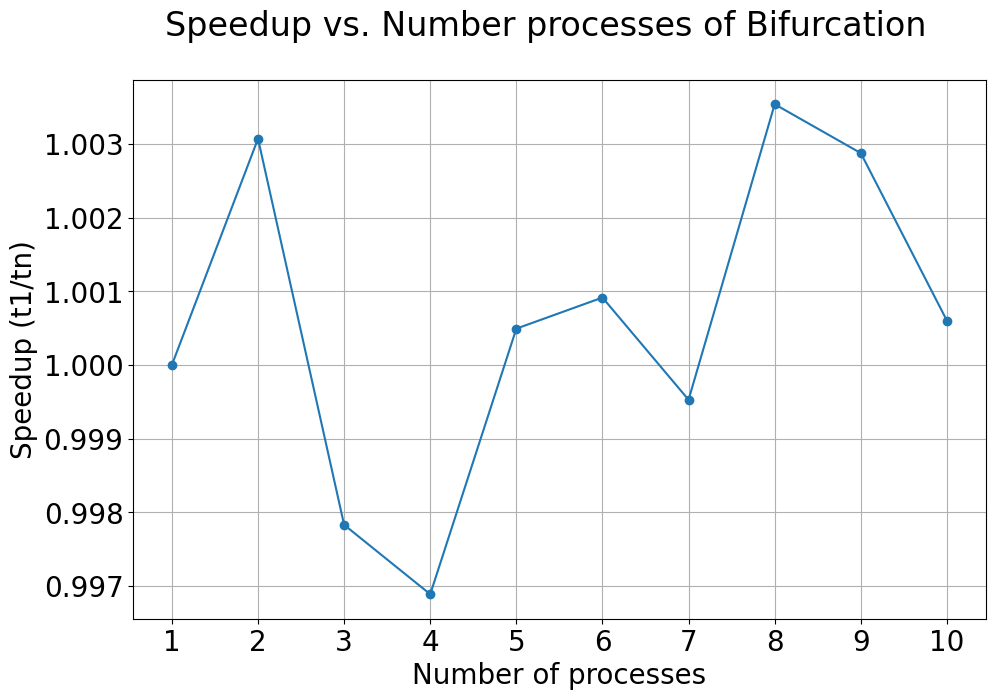

In [ ]:
speedup = time_arr[0] / np.array(time_arr)

plt.plot(processes, speedup, marker='o')
plt.xticks(processes)
plt.suptitle('Speedup vs. Number processes of Bifurcation')
plt.xlabel('Number of processes')
plt.ylabel('Speedup (t1/tn)')
plt.grid(True)
plt.show()

# 3. Implement parallel version of spectrogram

In [ ]:
%%writefile get_spectogram.py
import numpy as np

def get_specgram(t, y, window_positions, window_width, freq_limit=10):
    t_space = t
    w_spec = np.fft.fftfreq(len(y), d=(t_space[1]-t_space[0]) / 2 / np.pi)

    freq_limit_idx = np.where(w_spec >= freq_limit)[0][0] if freq_limit else -1
    w_spec = w_spec[:freq_limit_idx]

    spec_per_step = np.array([]).reshape(0, freq_limit_idx)
    for w_pos in window_positions:
        window_function = np.exp(-(t_space - w_pos) ** 2 / 2 / window_width ** 2)
        y_window = y * window_function

        sp = np.fft.fft(y_window)
        sp = np.abs(sp) ** 2
        sp = sp[:freq_limit_idx]
        spec_per_step = np.vstack([spec_per_step, sp])

    spec_per_step = np.array(spec_per_step).T
    return w_spec, spec_per_step, window_width

Overwriting get_spectogram.py


In [ ]:
%%writefile spectrogram.py

from mpi4py import MPI
import numpy as np
from get_spectogram import *
import time

comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()

t = np.linspace(-20*2*np.pi, 20*2*np.pi, 3**15)

y = np.sin(t) * np.exp(-t**2/2/20**2)
y = y + np.sin(3*t) * np.exp(-(t-5*2*np.pi)**2/2/20**2)
y = y + np.sin(5.5*t) * np.exp(-(t-10*2*np.pi)**2/2/5**2)
y = y + np.sin(4*t) * np.exp(-(t-7*2*np.pi)**2/2/20**2)

nwindowsteps = 60 if size != 7 else 63
window_width = (t[-1] - t[0]) / nwindowsteps
window_positions_space = np.linspace(t[0], t[-1], nwindowsteps)

win_pos_per_rank = np.split(window_positions_space, size)
win_pos_subspace = win_pos_per_rank[rank]

_, spec_per_step, _ = get_specgram(t, y, win_pos_subspace, window_width)

result_arr = comm.gather(spec_per_step, root=0)

if rank == 0:
    result_arr = np.concatenate(result_arr, 1)
    plt.imshow(result_arr, aspect='auto', cmap='inferno', origin='lower', extent=[0, 1, 0, 10])
    plt.colorbar(label='Power spectrum, arb. units')
    plt.ylabel('Frequency, arb. units')
    plt.xlabel('Window position')
    plt.title('4-wave packet')

Overwriting spectrogram.py


In [ ]:
!mpirun --oversubscribe --allow-run-as-root -n 3 python3 bifurcation.py
print('MPI done')

MPI done


# 4. Plot speedup vs. number of processes

In [ ]:
time_arr_1 = []
processes = range(1, 11)
for i in processes:
    print(f'Process {i}: \n', end='')
    t = %timeit -o !mpirun -n {i} --oversubscribe --allow-run-as-root python3 spectrogram.py
    time_arr_1.append(t.best)

Process 1: 
111 ms ± 4.02 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Process 2: 
115 ms ± 5.43 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Process 3: 
104 ms ± 411 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Process 4: 
104 ms ± 301 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Process 5: 
104 ms ± 370 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Process 6: 
104 ms ± 269 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Process 7: 
104 ms ± 388 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Process 8: 
104 ms ± 213 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Process 9: 
104 ms ± 311 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Process 10: 
104 ms ± 219 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


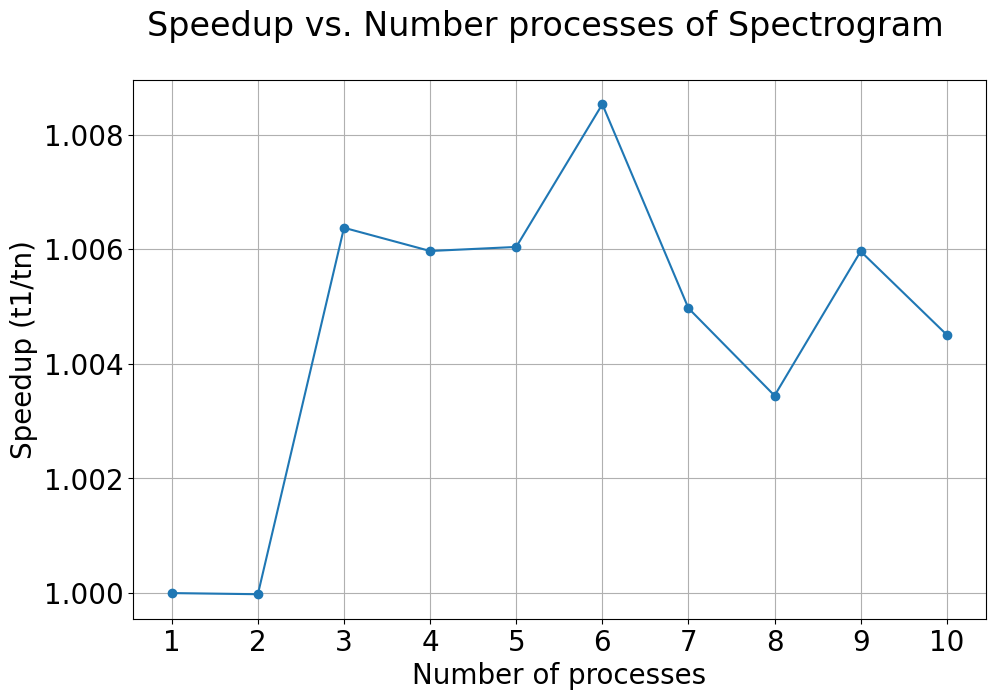

In [ ]:
speedup_1 = time_arr_1[0] / np.array(time_arr_1)

plt.plot(processes, speedup_1, marker='o')
plt.xticks(processes)
plt.suptitle('Speedup vs. Number processes of Spectrogram')
plt.xlabel('Number of processes')
plt.ylabel('Speedup (t1/tn)')
plt.grid(True)
plt.show()